In [1]:
!git clone https://github.com/CVMI-Lab/UHDM.git
%cd UHDM
#!conda env update -n base -f environment.yaml

Cloning into 'UHDM'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 133 (delta 20), reused 17 (delta 17), pack-reused 112
Receiving objects: 100% (133/133), 16.49 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/UHDM


In [2]:
!pip install -q lpips
!pip install -q tensorboardx==2.2
!pip install protobuf==3.20.*
!pip install thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 826.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 1.6 MB/s eta 0:00:00


In [3]:
!bash scripts/download_model.sh

Downloading...
From (original): https://drive.google.com/uc?id=1PyCLCytsu4F8gEk_04a8Qs7pcsHazAie
From (redirected): https://drive.google.com/uc?id=1PyCLCytsu4F8gEk_04a8Qs7pcsHazAie&confirm=t&uuid=db464d47-4f72-4c8c-829d-80d8c5bbe8ca
To: /content/UHDM/pretrain_model/uhdm_large_checkpoint.pth
100% 42.8M/42.8M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HT_ubcAYRqzFIJ46XuPhrulJk2YFBIEl
To: /content/UHDM/pretrain_model/uhdm_checkpoint.pth
100% 23.9M/23.9M [00:00<00:00, 159MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1oqmpBM-3gDwEKRMKoS6cKT0-3_EzBPAf
From (redirected): https://drive.google.com/uc?id=1oqmpBM-3gDwEKRMKoS6cKT0-3_EzBPAf&confirm=t&uuid=0868c917-b7bc-4914-8e36-b0f8a632968e
To: /content/UHDM/pretrain_model/tip_large_checkpoint.pth
100% 42.8M/42.8M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CcYDakV9r6sZTsJvdkzC-uutAlOrexW8
To: /content/UHDM/pretrain_model/tip_checkpoint.pth
100% 23.9M/23.9M [00

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
import datetime
import logging
import lpips
import numpy as np
import torch
import argparse
import cv2
import torch.utils.data as data
import torchvision
import random
import torch.nn.functional as F
import torch.nn as nn
from tensorboardX import SummaryWriter
import torch.optim as optim
import os

In [6]:
from model.model import model_fn_decorator
from model.nets import my_model
from dataset.load_data import *

In [7]:
from tqdm import tqdm
from utils.loss_util import *
from utils.common import *

In [13]:
%%writefile demo_config/demo.yaml
## A quick demo play for your own data using our pre-trained model, no need to download datasets
GENERAL:
  GPU_ID: 2
  SEED: 123
  WORKER: 8
  SAVE_PREFIX: './test'
  EXP_NAME: 'exp'

DATA:
  DEMO_DATASET: /content/sample_data # Insert the root of your moire images

MODEL:
  EN_FEATURE_NUM: 48
  EN_INTER_NUM: 32
  DE_FEATURE_NUM: 64
  DE_INTER_NUM: 32
  SAM_NUMBER: 2 # Note this value needs to be consistent with the pre-trained model! i.e., 1 for ESDNet and 2 for ESDNet-L

TEST:
  SAVE_IMG: jpg # The file type (e.g., png, jpg) for saving the output image; set False to avoid saving
  LOAD_PATH: './pretrain_model/uhdm_large_checkpoint.pth' # Specify the checkpoint path

Overwriting demo_config/demo.yaml


In [14]:
import argparse
import yaml
import os
class Args():
    def __init__(self):
        self.config = '/content/UHDM/demo_config/demo.yaml'
args_cfg = Args()
assert args_cfg.config is not None
with open(args_cfg.config, 'r') as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
for key in args:
    for k, v in args[key].items():
        setattr(args_cfg, k, v)

In [15]:
os.mkdir(args['GENERAL']['SAVE_PREFIX'])
args['TEST_RESULT_DIR'] = os.path.join(args['GENERAL']['SAVE_PREFIX'], 'test_result')
os.mkdir(args['TEST_RESULT_DIR'])
args['NETS_DIR'] = os.path.join(args['GENERAL']['SAVE_PREFIX'], 'net_checkpoints')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import logging
from PIL import Image
from PIL import ImageFile
import os

In [16]:
args

{'GENERAL': {'GPU_ID': 2,
  'SEED': 123,
  'WORKER': 8,
  'SAVE_PREFIX': './test',
  'EXP_NAME': 'exp'},
 'DATA': {'DEMO_DATASET': '/content/sample_data'},
 'MODEL': {'EN_FEATURE_NUM': 48,
  'EN_INTER_NUM': 32,
  'DE_FEATURE_NUM': 64,
  'DE_INTER_NUM': 32,
  'SAM_NUMBER': 2},
 'TEST': {'SAVE_IMG': 'jpg',
  'LOAD_PATH': './pretrain_model/uhdm_large_checkpoint.pth'},
 'TEST_RESULT_DIR': './test/test_result',
 'NETS_DIR': './test/net_checkpoints'}

In [17]:
model = my_model(en_feature_num=args['MODEL']['EN_FEATURE_NUM'],
                     en_inter_num=args['MODEL']['EN_INTER_NUM'],
                     de_feature_num=args['MODEL']['DE_FEATURE_NUM'],
                     de_inter_num=args['MODEL']['DE_INTER_NUM'],
                     sam_number=args['MODEL']['SAM_NUMBER'],
                     ).to(device)

In [18]:
if args['TEST']['LOAD_PATH']:
    load_path = args['TEST']['LOAD_PATH']
    save_path = args['TEST_RESULT_DIR']  + '/customer'
    log_path = args['TEST_RESULT_DIR'] + '/customer_result.log'
else:
    print('Please specify a checkpoint path in the config file!!!')
    raise NotImplementedError
os.mkdir(save_path)
if load_path.endswith('.pth'):
    model_state_dict = torch.load(load_path)
else:
    model_state_dict = torch.load(load_path)['state_dict']
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [19]:
test_path = args['DATA']['DEMO_DATASET']

args['BATCH_SIZE'] = 1

In [20]:
class demo_data_loader(data.Dataset):

    def __init__(self, image_list):
        self.image_list = image_list

    def __getitem__(self, index):
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        data = {}
        path_src = self.image_list[index]
        number = os.path.split(path_src)[-1]
        number = number.split('.')[0]

        img = Image.open(path_src).convert('RGB')
        img = default_toTensor(img)

        data['in_img'] = img
        data['number'] = number

        return data

    def __len__(self):
        return len(self.image_list)
def _list_image_files_recursively(data_dir):
        file_list = []
        for home, dirs, files in os.walk(data_dir):
            for filename in files:
                ext = filename.split(".")[-1]
                if ext.lower() in ["jpg", "jpeg", "png", "gif", "webp"]:
                    file_list.append(os.path.join(home, filename))
        file_list.sort()
        return file_list


data_files = _list_image_files_recursively(data_dir=test_path)
dataset = demo_data_loader(data_files)

DemoImgLoader = data.DataLoader(
    dataset, batch_size=args['BATCH_SIZE'], shuffle=True, num_workers=args['GENERAL']['WORKER'], drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
def test_model_fn(args, data, model, save_path, device):
    # prepare input and forward
    in_img = data['in_img'].to(device)
    number = data['number']
    b, c, h, w = in_img.size()

    # pad image such that the resolution is a multiple of 32
    w_pad = (math.ceil(w/32)*32 - w) // 2
    h_pad = (math.ceil(h/32)*32 - h) // 2
    w_odd_pad = w_pad
    h_odd_pad = h_pad
    if w % 2 == 1:
        w_odd_pad += 1
    if h % 2 == 1:
        h_odd_pad += 1

    in_img = img_pad(in_img, w_pad=w_pad, h_pad=h_pad, w_odd_pad=w_odd_pad, h_odd_pad=h_odd_pad)

    with torch.no_grad():
        out_1, out_2, out_3 = model(in_img)
        if h_pad != 0:
            out_1 = out_1[:, :, h_pad:-h_odd_pad, :]
        if w_pad != 0:
            out_1 = out_1[:, :, :, w_pad:-w_odd_pad]

    # save images
    if args['TEST']['SAVE_IMG']:
        out_save = out_1.detach().cpu()
        torchvision.utils.save_image(out_save, save_path + '/' + 'test_%s' % number[0] + '.%s' % args['TEST']['SAVE_IMG'])

In [22]:
tbar = tqdm(DemoImgLoader)
for batch_idx, data in enumerate(tbar):
    model.eval()
    test_model_fn(args, data, model, save_path, device)
    desc = 'Test demo'
    tbar.set_description(desc)
    tbar.update()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Test demo: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


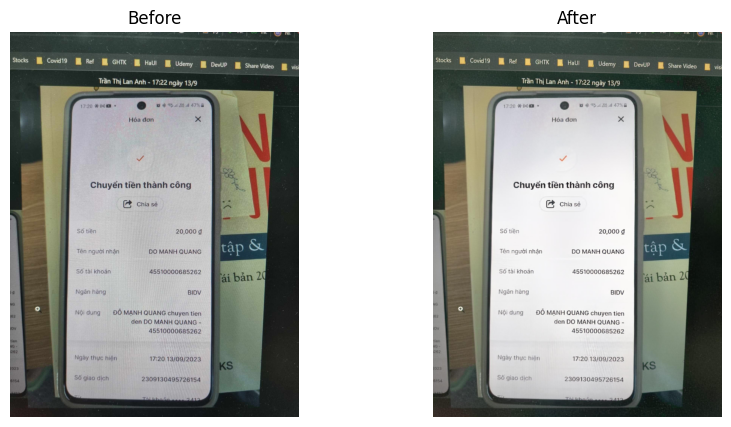

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Đường dẫn của hình ảnh
image_path1 = "/content/sample_data/eb9ddeac-bfc8-48a9-aad2-e7c117e5941e.jpg"
image_path2 = "/content/UHDM/test/test_result/customer/test_eb9ddeac-bfc8-48a9-aad2-e7c117e5941e.jpg"
# Đọc hình ảnh
image1 = mpimg.imread(image_path1)
image2 = mpimg.imread(image_path2)
# Hiển thị hình ảnh
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Before')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('After')
plt.axis('off')
plt.show()